# 美國情境喜劇《Friends》對白的文本分析



## 一、資料集介紹

資料集取自Kaggle，內容是美國情境喜劇《Friends》的對白台詞，共有56329筆資料，6個欄位

資料集欄位包括：
1. 季數(Season)：共10季
2. 集數(Episode)：每季集數略有不同，大部分集數落在24集左右
3. 場景(Scene)：標記不同場景與情境
4. 角色(Character)：說出台詞的角色，六位主要角色包括Rachel, Monica, Phoebe, Joey, Chandler和Ross。
5. 台詞順序(Line Index)：每集內的台詞編號，用來標識每句台詞在該集中的順序
6. 台詞(Line)：包含角色的對白，即每句台詞的文字內容。


## 二、動機與目的

**分析動機**：美國情境喜劇《Friends》，台灣又稱《六人行》，於1994年9月22日首播，並於2004年5月6日結束，共10季。
劇情圍繞著六位朋友在紐約市的生活、愛情和工作展開，情節既貼近現實又充滿幽默感。這種結合使得觀眾既能從中找到共鳴，又能享受輕鬆歡樂的觀賞體驗，因此廣受全球歡迎。

我們選擇《Friends》是因為此喜劇是被大眾所認為最經典的喜劇之一，並且多樣化的幽默方式吸引了不同年齡層和文化背景的觀眾。
即使是非常久遠的影集，但因為重播、串流平台吸引到了新的觀眾，因此影響力持續到了現在，不少人(包括組員)也都收看並重複觀看好幾遍。

**分析目的**：我們透過社群媒體分析課程所學到的NLP方法，來處理與分析對白文本，並根據分析結果，對劇情結構、角色塑造和文本風格提出洞察。

主要可分為三大方面：

1. **情緒分析**：觀察對白中常出現的正面、負面詞彙，視覺化來分析劇情中的情感與走向。
2. **主題模型**：根據不同集數做主題模型分析，來觀察每集是否有明確的主題類別。
3. **角色關聯**：透過角色之間的關聯，可以探討角色之間的互動模式，這對於理解劇情發展具有重要意義。


## 三、情緒分析、實體識別

【先將資料集進行斷詞、停用字處理，使用了兩個方法lexicon-base以及coreNLP來分析資料集】

### 1. 套件

In [ ]:
# 安裝會使用到的套件
%pip install stanza ipywidgets wordcloud textblob
# 會有不相容問題
%pip install --upgrade stanza
%pip install --upgrade protobuf
%pwd

In [ ]:
import stanza
from stanza.server import CoreNLPClient

import os
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import re

from nltk.parse import CoreNLPParser
from nltk.parse.corenlp import *
from wordcloud import WordCloud

import matplotlib.pyplot as plt

In [ ]:
# 下載斷句需要的資源
nltk.download('punkt')
# 下載POS tagger需要的資源
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

# 下載coreNLP模型，預設會在/stanza_corenlp裡面
stanza.install_corenlp("./stanza_corenlp")

In [ ]:
os.environ['CORENLP_HOME'] = "./stanza_corenlp" # 因為自訂下載路徑，所以要設定環境參數

In [ ]:
# 設定 CoreNLPClient with some basic annotators, a memory allocation of 4GB, and port number 9999
client = CoreNLPClient(
            # client要處理的項目
            annotators=['tokenize','ssplit','pos','lemma','ner','entitymentions', 'parse', 'sentiment'],
            memory='4G',
            endpoint='http://localhost:9999',
            # If set to False, the server process will print detailed error logs
            be_quiet=True
        )

# Start the background server and wait for some time
# Note that in practice this is totally optional, as by default the server will be started when the first annotation is performed
client.start()
import time; time.sleep(5)

INFO:stanza:Writing properties to tmp file: corenlp_server-8e73517211e54b84.props
INFO:stanza:Starting server with command: java -Xmx4G -cp ./stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9999 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-8e73517211e54b84.props -annotators tokenize,ssplit,pos,lemma,ner,entitymentions,parse,sentiment -preload -outputFormat serialized


### 2. 資料處理

In [ ]:
df = pd.read_csv("dialogue_data.csv")
df['Line'] = df['Line'].astype(str)

df

,Season,Episode,Line Index,Scene,Character,Line
0,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable. It’s been like a half an...
1,1,16,1,Rift’s Restaurant,Joey,"There’s the waitress. Excuse me, Miss. Hello, ..."
2,1,16,2,Rift’s Restaurant,Chandler,It’s Phoebe! Hi!
3,1,16,3,Rift’s Restaurant,Ursula,"Hi. Okay, will that be all?"
4,1,16,4,Rift’s Restaurant,Chandler,"Wait, wait! Wh-what are you doing here?"
...,...,...,...,...,...,...
56324,10,17,561,Monica and Chandler's apartment. Chandler and ...,Chandler,"Oh, it's gonna be okay."
56325,10,17,562,Monica and Chandler's apartment. Chandler and ...,Rachel,(crying) Do you guys have to go to the new hou...
56326,10,17,563,Monica and Chandler's apartment. Chandler and ...,Monica,We got some time.
56327,10,17,564,Monica and Chandler's apartment. Chandler and ...,Rachel,"Okay, should we get some coffee?"


#### 2.1 斷詞

In [ ]:
# 刪除標點符號/數字/換行符號
df["Line"] = df["Line"].apply(lambda x: re.sub(r'[^\w\s]','', x))
#使用NLTK的斷詞函式word_tokenize進行斷詞
token_df = df.assign(token = df['Line'].apply(nltk.word_tokenize)).explode('token')
#將token統一為全小寫
lowerWord_df = token_df.assign(token= token_df['token'].str.lower())
lowerWord_df

,Season,Episode,Line Index,Scene,Character,Line,token
0,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,this
0,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,is
0,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,unbelievable
0,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,its
0,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,been
...,...,...,...,...,...,...,...
56327,10,17,564,Monica and Chandler's apartment. Chandler and ...,Rachel,Okay should we get some coffee,get
56327,10,17,564,Monica and Chandler's apartment. Chandler and ...,Rachel,Okay should we get some coffee,some
56327,10,17,564,Monica and Chandler's apartment. Chandler and ...,Rachel,Okay should we get some coffee,coffee
56328,10,17,565,Monica and Chandler's apartment. Chandler and ...,Chandler,Sure Where,sure


#### 2.2 Stemming

In [ ]:
# stemming 使用字根方式表達，把字尾去掉
porter = PorterStemmer()
type(porter)

# 小提醒：nltk許多function變數規定為字串，因此可以先將word轉為字串格式，以確保後續不會有錯誤
lowerWord_df['token'] = lowerWord_df['token'].astype(str)
stem_df = lowerWord_df.assign(stem_word= lowerWord_df['token'].apply(porter.stem)).reset_index(drop=True)
stem_df

,Season,Episode,Line Index,Scene,Character,Line,token,stem_word
0,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,this,thi
1,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,is,is
2,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,unbelievable,unbeliev
3,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,its,it
4,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,been,been
...,...,...,...,...,...,...,...,...
647874,10,17,564,Monica and Chandler's apartment. Chandler and ...,Rachel,Okay should we get some coffee,get,get
647875,10,17,564,Monica and Chandler's apartment. Chandler and ...,Rachel,Okay should we get some coffee,some,some
647876,10,17,564,Monica and Chandler's apartment. Chandler and ...,Rachel,Okay should we get some coffee,coffee,coffe
647877,10,17,565,Monica and Chandler's apartment. Chandler and ...,Chandler,Sure Where,sure,sure


#### 2.3 停用字

In [ ]:
# 初次使用需要安裝nltk中的停用字資源
nltk.download('stopwords')
# 使用nltk的stop_words
stops = stopwords.words('english')
# 手動加入停用字(觀察文字雲後持續調整)
newStops = ['could', 'would', 'much', 'must','im','ok','oh']
stops.extend(newStops)
#移除停用字
noStop_df = stem_df[~stem_df['token'].isin(stops)]
noStop_df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Season,Episode,Line Index,Scene,Character,Line,token,stem_word
2,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,unbelievable,unbeliev
5,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,like,like
7,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,half,half
9,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,hour,hour
14,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,cartoon,cartoon
...,...,...,...,...,...,...,...,...
647870,10,17,563,Monica and Chandler's apartment. Chandler and ...,Monica,We got some time,time,time
647871,10,17,564,Monica and Chandler's apartment. Chandler and ...,Rachel,Okay should we get some coffee,okay,okay
647874,10,17,564,Monica and Chandler's apartment. Chandler and ...,Rachel,Okay should we get some coffee,get,get
647876,10,17,564,Monica and Chandler's apartment. Chandler and ...,Rachel,Okay should we get some coffee,coffee,coffe


### 3. 詞頻、文字雲

In [ ]:
#出現詞彙的頻率前15名
freq_df = pd.DataFrame(noStop_df['stem_word'].value_counts()).reset_index()
freq_df.columns = ['word', 'freq']
freq_df.head(15)

,word,freq
0,okay,4717
1,yeah,4478
2,know,4395
3,well,4096
4,dont,3903
5,go,3718
6,get,3567
7,hey,3552
8,look,3308
9,na,3303


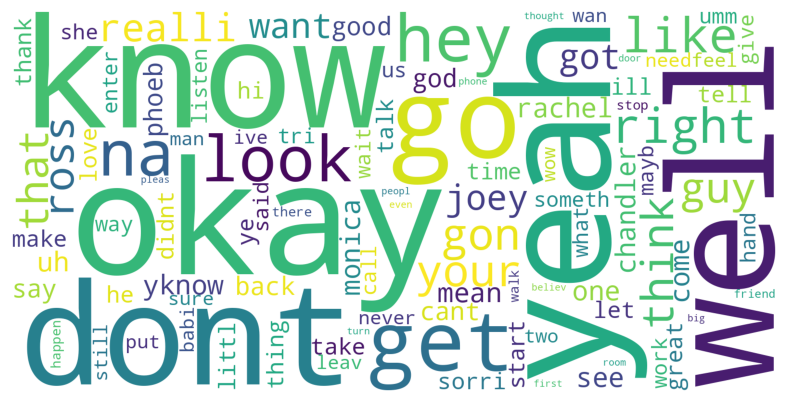

In [ ]:
text = freq_df.set_index('word').to_dict()
wordcloud = WordCloud(scale = 4, background_color = 'white', max_words=100).generate_from_frequencies(text['freq'])
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

【分析結果：從文字雲看到最常出現的詞彙，多為日常生活用語】

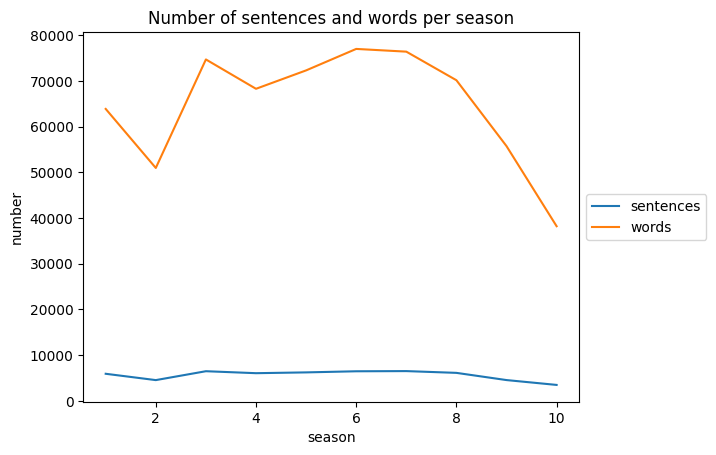

In [ ]:
season_count = pd.DataFrame({
    'season': df.groupby('Season').size().index,
    'sentence': df.groupby('Season').size().values,
    'word': token_df.groupby('Season').size().values,
})
season_count

plt.plot(season_count['season'].values, season_count['sentence'].values ,label = 'sentences')
plt.plot(season_count['season'].values, season_count['word'].values, label = 'words')

plt.title('Number of sentences and words per season') # 標題
plt.xlabel('season') # x軸標題
plt.ylabel('number') # y軸標題
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10) # 顯示label在右邊
plt.show()

### 4. lexicon-base

In [ ]:
# 讀取情緒字典
en_dict_path = "./liwc/LIWC_EN.csv"
liwc_dict = pd.read_csv(en_dict_path)
liwc_dict = liwc_dict.rename(columns={'name': 'token', "class": 'sentiments'})
liwc_dict['sentiments'].unique()

array(['affect', 'positive', 'negative', 'anx', 'anger', 'sad'],
      dtype=object)

In [ ]:
df = noStop_df.copy()
liwc_df = pd.merge(df, liwc_dict, how = 'left')
print(liwc_df['sentiments'].value_counts())
liwc_df

sentiments
affect      37575
positive    27996
negative     9368
sad          2925
anger        2204
anx          1030
Name: count, dtype: int64


,Season,Episode,Line Index,Scene,Character,Line,token,stem_word,sentiments
0,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,unbelievable,unbeliev,NaN
1,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,like,like,NaN
2,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,half,half,NaN
3,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,hour,hour,NaN
4,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable Its been like a half an h...,cartoon,cartoon,NaN
...,...,...,...,...,...,...,...,...,...
372575,10,17,564,Monica and Chandler's apartment. Chandler and ...,Rachel,Okay should we get some coffee,okay,okay,positive
372576,10,17,564,Monica and Chandler's apartment. Chandler and ...,Rachel,Okay should we get some coffee,get,get,NaN
372577,10,17,564,Monica and Chandler's apartment. Chandler and ...,Rachel,Okay should we get some coffee,coffee,coffe,NaN
372578,10,17,565,Monica and Chandler's apartment. Chandler and ...,Chandler,Sure Where,sure,sure,affect


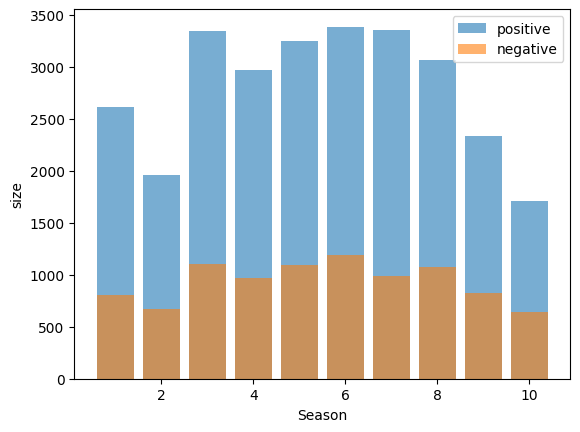

In [ ]:
# 算出每季情緒總和(sentiment_count)

sentiment_count = pd.DataFrame(liwc_df.groupby(['Season', 'sentiments']).size()).reset_index()

mask = (sentiment_count['sentiments'] == "positive") | (sentiment_count['sentiments'] == "negative")
sentiment_count = sentiment_count.loc[mask]

sentiment_count = sentiment_count.rename(columns={0: 'size'})
sentiment_count
#取出每季的正面、負面詞彙數量
pos = sentiment_count[sentiment_count['sentiments']=='positive']
neg = sentiment_count[sentiment_count['sentiments']=='negative']
#畫出長條圖
colors = ["tab:blue",  "tab:orange"]
fig, ax = plt.subplots()

ax.bar(pos['Season'],
       pos['size'],
       color = colors[0],
       alpha = 0.6,
       align='center')
ax.bar(neg['Season'],
       neg['size'],
       color = colors[1],
       alpha = 0.6,
       align='center')
plt.xlabel('Season')
plt.ylabel('size')

ax.legend(['positive','negative'], loc ='upper right')
plt.show()

【分析結果：長條圖顯示了每個季所出現過的正負面詞彙，因為喜劇的緣由，正面詞彙會稍多一點】

排名悲傷情緒的集數

In [ ]:
sad = liwc_df[liwc_df['sentiments'].isin(['sad'])]
sad

sad_counts = sad.groupby(['Season', 'Episode']).size().reset_index(name='sad_count') # sad的次數
total_lines = liwc_df.groupby(['Season', 'Episode']).size().reset_index(name='total_count') # total的次數
total_lines
merged_df = pd.merge(sad_counts, total_lines, on=['Season', 'Episode'])
merged_df['sad_frequency'] = merged_df['sad_count'] / merged_df['total_count']
ranked_df = merged_df.sort_values(by='sad_frequency', ascending=False).reset_index(drop=True)
ranked_df

,Season,Episode,sad_count,total_count,sad_frequency
0,9,8,2,88,0.022727
1,2,15,22,1244,0.017685
2,6,14,28,1778,0.015748
3,3,12,25,1675,0.014925
4,6,6,27,1887,0.014308
...,...,...,...,...,...
212,1,17,4,1696,0.002358
213,9,4,2,861,0.002323
214,4,19,3,1309,0.002292
215,8,6,4,1880,0.002128


【分析結果：透過情緒比例的季數集數排名，我們可以發現某集的悲傷程度可能會高一點，在喜劇中悲傷比例較高，可能表示劇情與挫折、離別、人際關係問題有關】

### 5. coreNLP

In [ ]:
def get_nlp_result(df, text_col, id_col):

    print("Starting a server with the Python \"with\" statement...")

    start = time.time()

    with CoreNLPClient(
        annotators = ['tokenize','ssplit', 'pos', 'lemma', 'ner','sentiment','entitymentions'],
        memory = '4G', endpoint = 'http://localhost:7777' , be_quiet=True,
    ) as client:

        token_list = []
        senti_list = []
        mention_list = []

        for index, row in df.iterrows(): # document level
            # send text into client
            document = client.annotate(row[text_col])
            # print(f"{'Word':12s}\t{'Lemma':12s}\t{'POS':6s}\t{'NER'}")

             # sentence level
            for i, sent in enumerate(document.sentence):
                s = ""
                # token level
                for t in sent.token:
                    s = s + " " + t.word # for sentence
                    # print("{:12s}\t{:12s}\t{:6s}\t{}".format(t.word, t.lemma, t.pos, t.ner))
                    # save lemma, pos, ner
                    temp_token = [row[id_col],t.word, t.lemma, t.pos, t.ner]
                    token_list.append(temp_token)
                # print("[Sentence {}:{}_____________]".format(i+1, s))

                # save sentiment, mention
                temp_senti = [row[id_col], s, sent.sentiment]
                senti_list.append(temp_senti)

                for mention in sent.mentions:
                    try:
                        # print(mention.entityMentionText, mention.ner)
                        temp_mention = [row[id_col], mention.entityMentionText, mention.ner]
                        mention_list.append(temp_mention)
                    except:
                        continue

        token_table = pd.DataFrame(data=token_list,
                            columns=[id_col,'word','lemma','pos','ner'])

        senti_table = pd.DataFrame(data=senti_list,
                            columns=[id_col,'sentence', 'sentiment'])

        mention_table = pd.DataFrame(data=mention_list,
                            columns=[id_col, 'mention','ner'])

        end = time.time()

        print("time costing: {}".format(end - start))
        print("\nThe server should be stopped upon exit from the \"with\" statement.")

        return token_table, senti_table , mention_table

取第一季第一集(試播集)來做分析，來觀察此集的情緒以及提及之實體

In [ ]:
df_season1 = df[(df['Season'] == 1)&(df['Episode']==1)]
df_season1 = df_season1[['Line Index','Line']]
df_season1

,Line Index,Line
1017,0,Theres nothing to tell Hes just some guy I wor...
1018,1,Cmon youre going out with the guy Theres gotta...
1019,2,All right Joey be nice So does he have a hump...
1020,3,Wait does he eat chalk
1021,4,Just cause I dont want her to go through what ...
...,...,...
1312,295,Yeah Yeah Ill have a cup of coffee
1313,296,Kids new dream Im in Las Vegas Rachel sits dow...
1314,297,To Rachel Ahh miss More coffee
1315,298,Ugh To another customer thats leaving Excuse m...


In [ ]:
# 找出NER、POS和sentiment分析結果
tokens, sentiment, mention  = get_nlp_result(df_season1,'Line','Line Index') # 資料框, 要處理的文字欄位名, id 欄位名
# total time costing: 148


INFO:stanza:Writing properties to tmp file: corenlp_server-f668f055f30e4339.props
INFO:stanza:Starting server with command: java -Xmx4G -cp ./stanza_corenlp/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 7777 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-f668f055f30e4339.props -annotators tokenize,ssplit,pos,lemma,ner,sentiment,entitymentions -preload -outputFormat serialized


Starting a server with the Python "with" statement...
time costing: 148.5612030029297

The server should be stopped upon exit from the "with" statement.


In [ ]:
# 字詞標註dataframe # 文章id, 字詞, 詞性還原, 詞性, 實體
tokens.head()


,Line Index,word,lemma,pos,ner
0,0,Theres,theres,IN,O
1,0,nothing,nothing,NN,O
2,0,to,to,TO,O
3,0,tell,tell,VB,O
4,0,Hes,he,NNS,ORGANIZATION


In [ ]:
# 情緒分析dataframe # 文章id, 句子, 情緒
sentiment.head()


,Line Index,sentence,sentiment
0,0,Theres nothing to tell Hes just some guy I wo...,Negative
1,1,Cmon youre going out with the guy Theres got ...,Negative
2,2,All right Joey be nice So does he have a hump...,Positive
3,3,Wait does he eat chalk,Neutral
4,4,Just cause I do nt want her to go through wha...,Neutral


In [ ]:
# 實體標註 dataframe # 文章id, 字詞, 實體
mention.head()

,Line Index,mention,ner
0,0,Hes,ORGANIZATION
1,1,him,PERSON
2,2,Joey,PERSON
3,2,he,PERSON
4,3,he,PERSON


In [ ]:
# 儲存結果
tokens.to_csv('raw_data/tokens_tp.csv', encoding = 'utf-8', index = False)
sentiment.to_csv('raw_data/sentiment_tp.csv', encoding = 'utf-8', index = False)
mention.to_csv('raw_data/mention_tp.csv', encoding = 'utf-8', index = False)

# 讀取已經執行完畢的結果
tokens = pd.read_csv('raw_data/tokens_tp.csv')
mention = pd.read_csv('raw_data/mention_tp.csv')
sentiment = pd.read_csv('raw_data/sentiment_tp.csv')

In [ ]:
mention['word_lower'] = mention['mention'].str.lower()
mention.tail()

,Line Index,mention,ner,word_lower
266,298,Las Vegas,CITY,las vegas
267,298,him,PERSON,him
268,298,He,PERSON,he
269,299,Las Vegas,CITY,las vegas
270,299,Liza Minelli,PERSON,liza minelli


#### 5.1 NER-PERSON

for ner: ['O']
for entityMention: ['PERSON']
for ner: ['O']
for entityMention: ['PERSON']


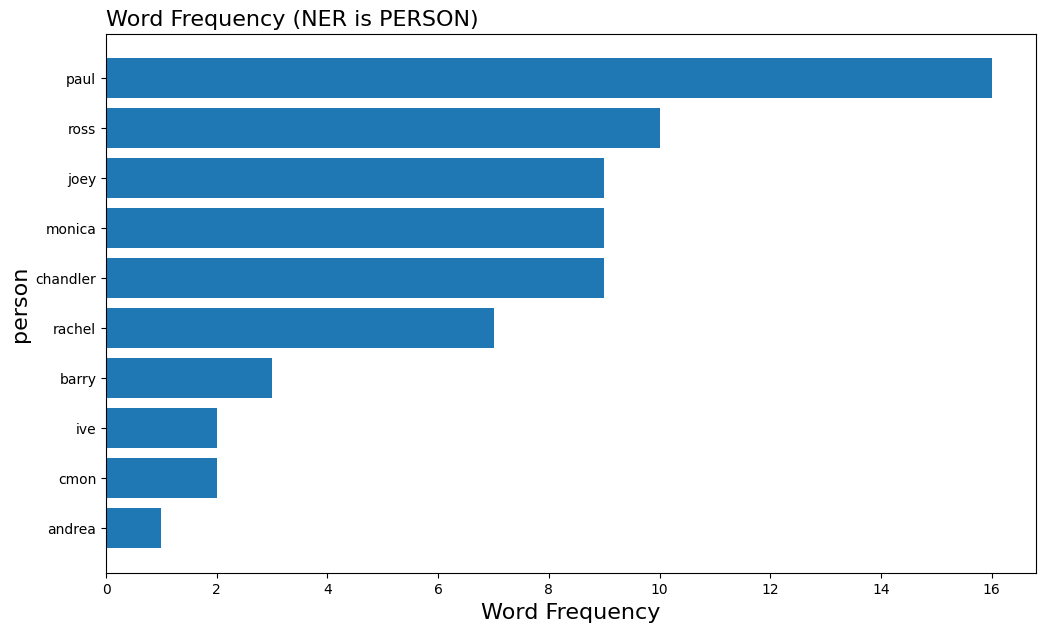

In [ ]:
# 查看 her 的 NER 分類
keyword_list = ['her']
print("for ner:", tokens.loc[tokens['word'] == 'her'].ner.unique())
print("for entityMention:", mention.loc[mention['word_lower'] == 'her'].ner.unique())

keyword_list = ['his']
print("for ner:", tokens.loc[tokens['word'] == 'his'].ner.unique())
print("for entityMention:", mention.loc[mention['word_lower'] == 'his'].ner.unique())

peo = mention.loc[mention['ner'] == 'PERSON']

# 手動移除coreNLP分不好的字詞
remove_l = ['her','his','he','she','him']
peo = peo[~peo.word_lower.isin(remove_l)]

peo_count = peo[['word_lower']].groupby(['word_lower'])['word_lower'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)
peo_count.head()

word = peo_count['word_lower']
count = peo_count['count']

fig, ax = plt.subplots(figsize =(12, 7))
ax.barh(word, count)
ax.invert_yaxis()
ax.set_title('Word Frequency (NER is PERSON)',loc ='left', size = 16)
ax.set_ylabel('person', size = 16)
ax.set_xlabel('Word Frequency', size = 16)
fig.show()

【分析結果：可以看到Paul被提到最多次，但它並不是六個主角之一，而是Monica剛認識的約會對象，為此集重要劇情發展配角之一。第二名~第六名為本劇主角，Phoebe未被提到可能是因為在本集並不是劇情發展人物】

In [ ]:
contains_paul = sentiment[sentiment['sentence'].str.contains('paul', case=False, na=False)]
sentiment_counts = contains_paul['sentiment'].value_counts()
print(sentiment_counts)
contains_paul


sentiment
Neutral     14
Negative     5
Name: count, dtype: int64


,Line Index,sentence,sentiment
74,74,over the intercom Its uh its Paul,Neutral
76,76,Whos Paul,Neutral
77,77,Paul the Wine Guy Paul,Neutral
78,78,Maybe Joey Wait Your not a real date tonight ...,Negative
87,87,normal voice No go on Its Paul the Wine Guy,Neutral
89,89,Hi come in Paul this is They are all lined up...,Neutral
90,90,Hey Paul Hi The Wine Guy Hey,Neutral
91,91,Im sorry I did nt catch your name Paul was it,Negative
94,94,Change Okay sit down Shows Paul in Two seconds,Negative
96,96,Hey Paul,Neutral


【分析結果：從關鍵字"Paul"找尋出現台詞的情緒並沒有正面的情緒，其中包含5句為負面，回顧此劇情可以發現，因為Paul是個騙子，所以提到Paul的態度和情緒都不是很好。】

#### 5.2 Sentiment Analysis

In [ ]:
# 看有哪些情緒
sentiment['sentiment'].unique()
# 看一下各情緒的分布
sentiment.groupby('sentiment')['sentiment'].agg(['count'])
# 將情緒轉為分數
def label_sentiment(row):
    if row['sentiment'] == "Very positive" :
        return 2
    if row['sentiment'] == "Positive" :
        return 1
    if row['sentiment'] == "Neutral" :
        return 0
    if row['sentiment'] == "Negative" :
        return -1
    if row['sentiment'] == "Very negative" :
        return -2

sentiment['sentimentValue'] = sentiment.apply(lambda row: label_sentiment(row), axis=1)
sentiment.head()

print(sentiment.groupby('sentiment')['sentiment'].agg(['count']))

               count
sentiment           
Negative          65
Neutral          190
Positive          43
Very positive      2


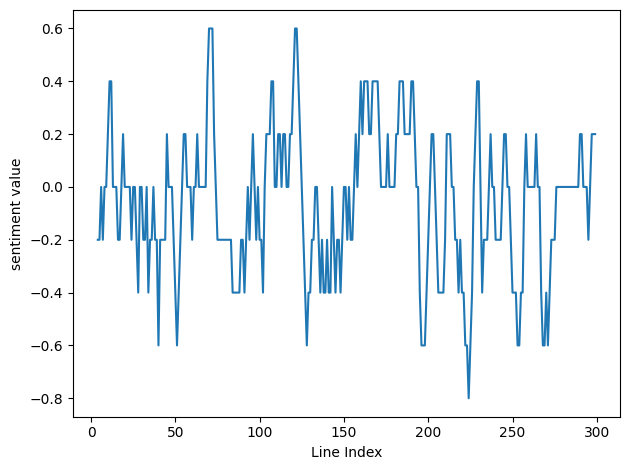

In [ ]:
#每5句取平均
sentiment['smoothed_sentiment'] = sentiment['sentimentValue'].rolling(window=5).mean()

# 情緒分數時間趨勢
plt.plot(sentiment['Line Index'].values, sentiment['smoothed_sentiment'].values , linestyle='solid')
plt.xlabel('Line Index') # x軸標題
plt.ylabel('sentiment value') # y軸標題
plt.tight_layout()
plt.show()

【分析結果：
+ Line Index(x軸)可看做此集的時間軸，雖然有很多波動，但似乎沒有明顯的上升或下降趨勢，情緒在正面和負面之間來回變化。
+ Neutral (中性) 的句數最多(190句)，大多數台詞情緒平淡，主要為大量日常對話，跟情景喜劇的風格相符。
+ Negative (負面) 的句數比正面多一點，這可能反映了角色遇到的困難或衝突，例如 Rachel 在婚禮上逃跑、Ross 面對離婚等情節。】

非常正面詞彙文字雲：只有2句的情緒屬於"非常正面"，想觀察是哪些詞彙

【分析結果："fine","hope","amazing"等等的正面詞彙】


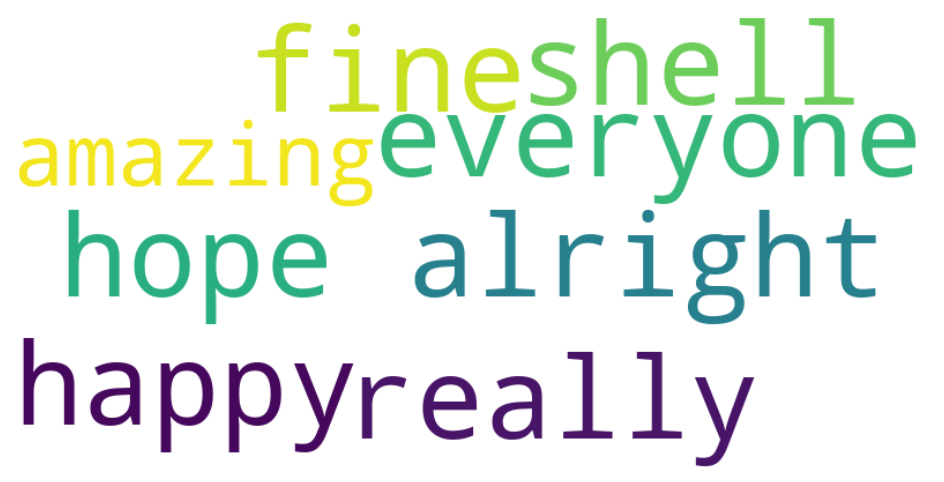

In [ ]:
# 把 token 的字詞降大小寫
tokens['lemma_lower'] = tokens['lemma'].str.lower()

# 挑出正面詞彙
positive = sentiment[sentiment['sentiment'].isin(['Very positive'])]
positive_words = pd.merge(positive,tokens,on='Line Index',how='left')

# 匯入預設的stop words，也可以自訂
stop_words = set(stopwords.words('english'))
stop_words.update(["could", "would", "might", "may", "im", "must","okay","cant","ill"])

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words,
                max_font_size=100, width=800, height = 400, background_color="white")\
                .generate(' '.join(positive_words['lemma_lower']))

# Display the generated image:
plt.figure(figsize = (12,6))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

負面詞彙文字雲

【分析結果："sorry","wait"等等的負面詞彙，主角Chandler也出現在負面句子裡面】

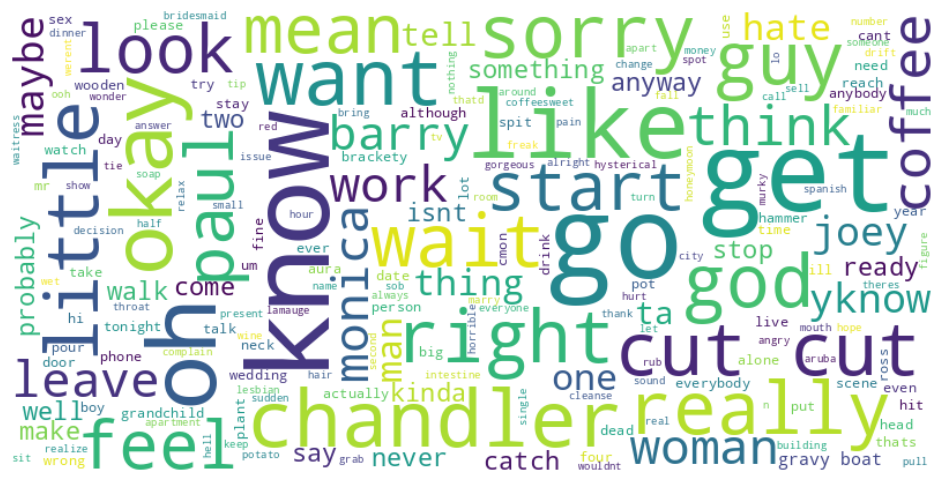

In [ ]:
negative = sentiment[sentiment['sentiment'].isin(['Negative'])]
negative_words = pd.merge(negative,tokens,on='Line Index',how='left')
# 匯入預設的stop words 也可以自訂
stop_words = set(stopwords.words('english'))
stop_words.update(["could", "would", "might", "may", "youre","im"])

# 可以設定字型大小和背景顏色
wordcloud = WordCloud(
                stopwords=stop_words,
                max_font_size=100, width=800, height = 400, background_color="white")\
                .generate(' '.join(negative_words['lemma_lower']))

# Display the generated image:
plt.figure(figsize = (12,6))
plt.imshow(wordcloud, interpolation="bilinear")

plt.axis("off")
plt.show()

## 四、主題模型

1.   資料前處理
2.   tf-idf + 2/3-gram
3.   LDA主題模型 + Bertopic模型



### 連接雲端硬碟

In [ ]:
import os

from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/SMA_project') #切換該目錄
os.listdir() #確認目錄內容

Mounted at /content/drive


['mainData.csv',
 'texts',
 'output.csv',
 'grouped_data.csv',
 '期末專案_主題模型講稿.docx',
 'img',
 '稿_1.gdoc',
 'friends_sentiment.ipynb',
 'Graph_角色關係',
 'dialogue_topic_model.ipynb']

### 下載套件與載入套建

In [ ]:
!pip install bertopic
!pip install gensim
!pip install nltk
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 M

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import LdaModel
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim_models


import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
import re
import os
from collections import Counter
from nltk.util import ngrams

ModuleNotFoundError: No module named 'pyLDAvis'

#### 1.資料前處理
 將原始txt統整成單一資料表，並新增場景、角色與對白

In [ ]:

def parse_text(file_path):
    # 使用re.IGNORECASE來使匹配不區分大小寫
    season_episode = re.match(r"s(\d+)e(\d+)", os.path.basename(file_path), re.IGNORECASE)
    if not season_episode:
        print(f"Cannot parse season and episode from filename: {file_path}")
        return []  # 返回空列表表示此文件無法解析

    season, episode = season_episode.groups()
    data = []

    with open(file_path, 'r', encoding='utf-8') as file:
        scene = None
        line_index = 0
        for line in file:
            # 改進場景匹配，只捕獲冒號之前的地點名
            scene_match = re.match(r"\[Scene: ([^,]+),", line)
            if scene_match:
                scene = scene_match.group(1).strip()

            # 確保不處理場景描述行作為對話
            elif ':' in line and scene and not line.startswith('['):
                character, dialogue = line.split(':', 1)
                data.append([season, episode, line_index, scene, character.strip(), dialogue.strip()])
                line_index += 1

    return data

def process_files(directory):
    all_data = []
    for filename in os.listdir(directory):
        if filename.endswith(".txt"):
            file_path = os.path.join(directory, filename)
            file_data = parse_text(file_path)
            all_data.extend(file_data)

    if all_data:
        df = pd.DataFrame(all_data, columns=['Season', 'Episode', 'Line Index', 'Scene', 'Character', 'Line'])
        #儲存檔案
        df.to_csv('output.csv', index=False)
    else:
        print("No data parsed. Please check the file names and contents.")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# TXT檔案存放在 'texts' 目錄下
process_files('texts')


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

# 讀取數據
df = pd.read_csv('./output.csv')  # 或者你的CSV文件路徑
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,Season,Episode,Line Index,Scene,Character,Line
0,1,16,0,Rift’s Restaurant,Chandler,This is unbelievable. It’s been like a half an...
1,1,16,1,Rift’s Restaurant,Joey,"There’s the waitress. Excuse me, Miss. Hello, ..."
2,1,16,2,Rift’s Restaurant,Chandler,It’s Phoebe! Hi!
3,1,16,3,Rift’s Restaurant,Ursula,"Hi. Okay, will that be all?"
4,1,16,4,Rift’s Restaurant,Chandler,"Wait, wait! Wh-what are you doing here?"


將每集的對白合併，新增每集唯一索引。

In [ ]:
# 創建一個新列 'Season_Episode' 來標識每一集
df['Season_Episode'] = df['Season'].astype(str) + 'E' + df['Episode'].astype(str)

# 確保所有的 Line 列都是字符串類型，將 NaN 轉換為 ""
df['Line'] = df['Line'].fillna('').astype(str)

# 再次創建一個新列 'Season_Episode' 來標識每一集
df['Season_Episode'] = df['Season'].astype(str) + 'E' + df['Episode'].astype(str)

# 接下來，對數據進行分組，並將每集的對白合併為一個長字符串
grouped_data = df.groupby('Season_Episode')['Line'].apply(' '.join).reset_index()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#合併季數跟集數成每一集的鍵值
print(len(grouped_data['Season_Episode']))
grouped_data.head()

219


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Season_Episode,Line
0,10E1,"Oh, the way you crushed Mike at ping pong was ..."
1,10E10,"Rachel, this is yours. Aah! Why? What are thes..."
2,10E11,"(to Rachel) Thank you so much for this. Oh, d'..."
3,10E12,Sven I don't understand what you're saying! Wh...
4,10E13,"All right, it seems pretty simple. Your first ..."


### 文本前處理，新增格式

用預設的NLTK停用字對篩選，並調整格式，方便後續製作字典跟詞袋模型。

In [ ]:
nltk.download('punkt')

# 資料前處理函數
# 改小寫、去除停用字
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    #tokens = [word for word in tokens if word.isalpha() and word not in custom_stopwords]
    return tokens

# 對每一行對白進行處理
grouped_data['processed'] = grouped_data['Line'].apply(preprocess)
# 將列表轉換為字串並存儲在新欄位中
grouped_data['concated'] = grouped_data['processed'].apply(lambda x: ' '.join(x))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
grouped_data.to_csv('grouped_data.csv', index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# 讀取數據
grouped_data= pd.read_csv('./grouped_data.csv')

In [ ]:
grouped_data.head(20)

,Season_Episode,Line,processed,concated
0,1.000000e+02,"Oh, the way you crushed Mike at ping pong was ...","['oh', 'way', 'crushed', 'mike', 'ping', 'pong...",oh way crushed mike ping pong wan na plays fin...
1,1.000000e+11,"Rachel, this is yours. Aah! Why? What are thes...","['rachel', 'aah', 'see', 'right', 'everybody',...",rachel aah see right everybody open ooh oh wow...
2,1.000000e+12,"(to Rachel) Thank you so much for this. Oh, d'...","['rachel', 'thank', 'much', 'oh', 'like', 'oh'...",rachel thank much oh like oh god elegant dirty...
3,1.000000e+13,Sven I don't understand what you're saying! Wh...,"['sven', 'understand', 'saying', 'wrong', 'flo...",sven understand saying wrong flowers lorkins h...
4,1.000000e+14,"All right, it seems pretty simple. Your first ...","['right', 'seems', 'pretty', 'simple', 'first'...",right seems pretty simple first line name clau...
5,1.000000e+15,Hey Mon? Was it weird changing your name to Ge...,"['hey', 'mon', 'weird', 'changing', 'name', 'f...",hey mon weird changing name felt nice acknowle...
6,1.000000e+16,Hey Phoebe. Hey. Everything ok? I’m just mad a...,"['hey', 'phoebe', 'hey', 'everything', 'ok', '...",hey phoebe hey everything ok mad agent estelle...
7,1.000000e+17,"Oh, wow, can you believe you're like three wee...","['oh', 'wow', 'believe', 'like', 'three', 'wee...",oh wow believe like three weeks away know mind...
8,1.000000e+18,"Breathe, breathe, breathe... Good. Next time, ...","['breathe', 'breathe', 'breathe', 'good', 'nex...",breathe breathe breathe good next time say bre...
9,1.000000e+03,"Oh, god. So adorable. Look at them sleeping th...","['oh', 'god', 'adorable', 'look', 'sleeping', ...",oh god adorable look sleeping like angels yeah...


#### 2.tf-idf + 2/3-gram

發現有很多口語化的用字，像是oh  yeah、okay  okay等等

In [ ]:
# 生成bi-grams和tri-grams
bigrams = []
trigrams = []
for tokens in grouped_data['processed']:
    bigrams.extend(ngrams(tokens, 2))
    trigrams.extend(ngrams(tokens, 3))

# 計算n-grams的出現次數
bigram_counts = Counter(bigrams)
trigram_counts = Counter(trigrams)

# 印出統計數量
print("Top 20 Bigrams:")
for bigram, count in bigram_counts.most_common(20):
    print(f"{bigram}: {count}")
print("\nTop 20 Bigrams:")
bigrams_list = [f"{bigram[0]} {bigram[1]}" for bigram, count in bigram_counts.most_common(20)]
print(bigrams_list)


print("\nTop 20 Trigrams:")
for trigram, count in trigram_counts.most_common(20):
    print(f"{trigram}: {count}")
print("\nTop 20 Trigrams:")
trigrams_list = [f"{trigram[0]} {trigram[1]} {trigram[2]}" for trigram, count in trigram_counts.most_common(20)]
print(trigrams_list)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top 20 Bigrams:
('gon', 'na'): 2632
('oh', 'god'): 1137
('wan', 'na'): 678
('hey', 'hey'): 566
('oh', 'yeah'): 463
('got', 'ta'): 457
('okay', 'okay'): 395
('yeah', 'yeah'): 271
('na', 'go'): 260
('know', 'know'): 256
('oh', 'oh'): 239
('yeah', 'well'): 237
('entering', 'hey'): 217
('na', 'get'): 196
('yeah', 'know'): 189
('hey', 'guys'): 186
('oh', 'well'): 178
('wait', 'minute'): 172
('ca', 'believe'): 172
('oh', 'know'): 171

Top 20 Bigrams:
['gon na', 'oh god', 'wan na', 'hey hey', 'oh yeah', 'got ta', 'okay okay', 'yeah yeah', 'na go', 'know know', 'oh oh', 'yeah well', 'entering hey', 'na get', 'yeah know', 'hey guys', 'oh well', 'wait minute', 'ca believe', 'oh know']

Top 20 Trigrams:
('gon', 'na', 'go'): 215
('gon', 'na', 'get'): 147
('oh', 'god', 'oh'): 110
('got', 'ta', 'go'): 107
('know', 'gon', 'na'): 107
('hey', 'hey', 'hey'): 107
('think', 'gon', 'na'): 100
('entering', 'hey', 'hey'): 89
('well', 'gon', 'na'): 77
('okay', 'gon', 'na'): 70
('god', 'oh', 'god'): 68
('gon',

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
# 計算TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(grouped_data['concated'])

# 取得詞彙表
feature_names = vectorizer.get_feature_names_out()

# 將TF-IDF矩陣轉換為DataFrame以便查看
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# 顯示TF-IDF結果中的高值詞彙
top_n = 20  # 設定要查看的前N個詞
top_n_words = tfidf_df.sum().sort_values(ascending=False).head(top_n)
print("Top TF-IDF words:")
print(top_n_words)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Top TF-IDF words:
oh          40.877724
know        31.644825
okay        31.199130
yeah        26.142197
well        22.498092
hey         20.727083
na          19.630192
right       18.849553
like        17.323289
get         15.828147
gon         15.774384
ross        14.402575
go          13.827411
really      13.725469
uh          13.020054
got         12.908772
joey        12.804332
think       12.537891
look        12.200650
chandler    11.369871
dtype: float64


In [ ]:
stopwords_candidate = list(top_n_words.index)
print(stopwords_candidate)

['oh', 'know', 'okay', 'yeah', 'well', 'hey', 'na', 'right', 'like', 'get', 'gon', 'ross', 'go', 'really', 'uh', 'got', 'joey', 'think', 'look', 'chandler']


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 新增停用字

In [ ]:
# 新增停用字字典
new_stopwords = [
    'gon', 'oh god', 'wan', 'na', 'hey', 'oh yeah', 'got ta', 'okay', 'yeah', 'know', 'oh', 'hey guys',
    'oh well', 'wait minute', 'ca believe', 'oh know', 'well', 'like', 'really', 'think', 'look',
    'ok', 'ca', 'na', 'uh', 'hi', 'ya', 'yes', 'um', 'please', 'guys', 'get', 'got',
    'joey', 'go', 'see', 'right', 'ross', 'chandler', 'monica', 'mean', 'would', 'god', 'say', 'want',
    'rachel', 'one', 'going', 'come', 'good', 'let', 'phoebe', 'great', 'guy', 'sorry', 'little', 'back', 'looks', 'thing', 'time', 'alright', 'tell', 'said'
]


In [ ]:
# 自定義停用詞
custom_stopwords = set(stopwords.words('english'))
custom_stopwords.update(new_stopwords)  # 新增你要的停用詞

In [ ]:
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    total_tokens = len(tokens)
    default_stopped = sum(1 for word in tokens if word in stop_words)
    custom_stopped = sum(1 for word in tokens if word in custom_stopwords)
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words and word not in custom_stopwords]
    return tokens, default_stopped, custom_stopped, total_tokens

In [ ]:
# 對每一行對白進行處理
grouped_data['processed'], grouped_data['default_stopped'], grouped_data['custom_stopped'], grouped_data['total_tokens'] = zip(*grouped_data['Line'].apply(preprocess))

# 將列表轉換為字串並存儲在新欄位中
grouped_data['concated'] = grouped_data['processed'].apply(lambda x: ' '.join(x))

# 統計被刪除的詞總數
total_default_stopped = grouped_data['default_stopped'].sum()
total_custom_stopped = grouped_data['custom_stopped'].sum()

# 計算被刪除的詞佔原文的百分比
total_stopped = total_default_stopped + total_custom_stopped
total_original_tokens = grouped_data['total_tokens'].sum()
percentage_stopped = (total_stopped / total_original_tokens) * 100 if total_original_tokens > 0 else 0

print(f"被刪除的詞佔原文的百分比為: {percentage_stopped:.2f}%")

被刪除的詞佔原文的百分比為: 88.70%


In [ ]:
grouped_data.head()

,Season_Episode,Line,processed,concated,default_stopped,custom_stopped,total_tokens
0,1.000000e+02,"Oh, the way you crushed Mike at ping pong was ...","[way, crushed, mike, ping, pong, plays, finger...",way crushed mike ping pong plays finger chandl...,1920,2557,5003
1,1.000000e+11,"Rachel, this is yours. Aah! Why? What are thes...","[aah, everybody, open, ooh, wow, beautiful, sc...",aah everybody open ooh wow beautiful scarf one...,55,72,137
2,1.000000e+12,"(to Rachel) Thank you so much for this. Oh, d'...","[thank, much, elegant, dirty, stuff, starting,...",thank much elegant dirty stuff starting stripp...,1346,1778,3727
3,1.000000e+13,Sven I don't understand what you're saying! Wh...,"[sven, understand, saying, wrong, flowers, lor...",sven understand saying wrong flowers lorkins h...,1049,1333,2751
4,1.000000e+14,"All right, it seems pretty simple. Your first ...","[seems, pretty, simple, first, line, name, cla...",seems pretty simple first line name claude rep...,1294,1748,3667


In [ ]:
# 建立詞袋模型
dictionary = corpora.Dictionary(grouped_data['processed'])
corpus = [dictionary.doc2bow(text) for text in grouped_data['processed']]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 3.LDA主題模型 + Bertopic模型

用CoherenceModel尋找比較好的主題數

In [ ]:
docs = grouped_data['processed'].tolist()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import time
import numpy as np
from gensim.models import CoherenceModel
t0 = time.time()

topic_num_list = np.arange(2, 16)
result = {"topic_num":[], "perplexity":[], "pmi":[]}
model_set = dict()


for topic_num in topic_num_list:
    # perplexity
    model = LdaModel(
        corpus = corpus,
        num_topics = topic_num ,
        id2word=dictionary,
        random_state = 1500,
        passes=5
        )

    loss = model.log_perplexity(corpus)
    pmi = CoherenceModel(model=model, texts=docs, coherence='c_npmi').get_coherence()
    perplexity = np.exp(-1. * loss)

    # model_set[f'k_{topic_num}'] = model

    result['topic_num'].append(topic_num)
    result['perplexity'].append(perplexity)
    result['pmi'].append(pmi)

print(f"花費時間: {time.time() - t0} sec")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


花費時間: 141.90671348571777 sec


In [ ]:
result = pd.DataFrame(result)
result

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,topic_num,perplexity,pmi
0,2,2973.867279,-0.015475
1,3,3007.538021,-0.011845
2,4,3054.112409,-0.009703
3,5,3086.836210,-0.010814
4,6,3132.565486,-0.017888
5,7,3177.313817,-0.013256
6,8,3216.436973,-0.015479
7,9,3262.678165,-0.022787
8,10,3308.973555,-0.017371
9,11,3352.038309,-0.015225


perplexity跟主題數呈正相關，隨著主題數的增加而增加，並沒有在低主題數有比較好的表現。

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='topic_num'>

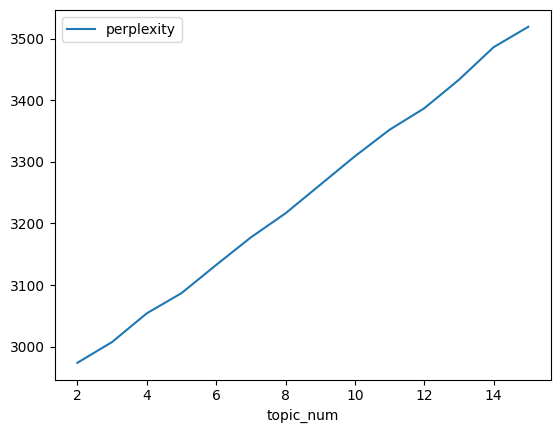

In [ ]:
result.plot.line(x='topic_num', y='perplexity')

PMI 的值都是負的，表示主題中的詞一致性較低，彼此之間的相關性不高。

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='topic_num'>

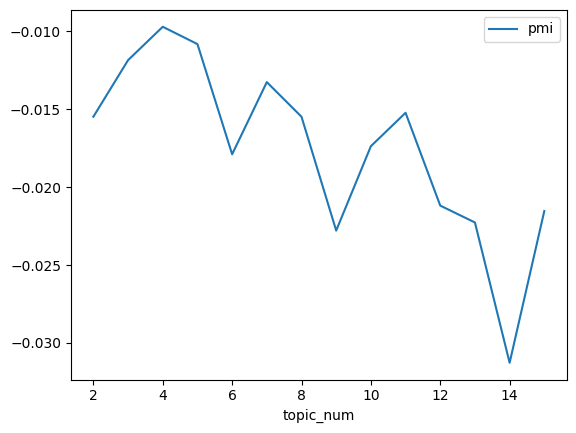

In [ ]:
result.plot.line(x='topic_num', y='pmi')

In [ ]:
ldamodel = LdaModel(
    corpus=corpus,
    id2word=dictionary, # 字典
    num_topics=4, # 生成幾個主題數
    random_state=2024, # 亂數
    passes = 100
)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LDA模型結果的主題關鍵詞效果依然不佳，還是口語常用字居多

In [ ]:
# 顯示每個主題的關鍵詞
for idx, topic in ldamodel.print_topics(-1):
    print(f"Topic: {idx}\nWords: {topic}\n")

Topic: 0
Words: 0.006*"love" + 0.005*"could" + 0.005*"something" + 0.005*"wait" + 0.004*"take" + 0.004*"make" + 0.004*"maybe" + 0.004*"us" + 0.004*"still" + 0.004*"umm"

Topic: 1
Words: 0.004*"could" + 0.004*"something" + 0.004*"umm" + 0.004*"take" + 0.004*"ah" + 0.003*"starts" + 0.003*"maybe" + 0.003*"much" + 0.003*"make" + 0.003*"wow"

Topic: 2
Words: 0.005*"could" + 0.005*"something" + 0.004*"love" + 0.004*"maybe" + 0.004*"take" + 0.004*"make" + 0.004*"wait" + 0.004*"sure" + 0.004*"umm" + 0.004*"way"

Topic: 3
Words: 0.005*"could" + 0.005*"phone" + 0.004*"something" + 0.004*"way" + 0.004*"love" + 0.004*"never" + 0.003*"take" + 0.003*"man" + 0.003*"umm" + 0.003*"maybe"



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


最後LDA模型跑出來的主題關鍵詞效果依然不佳，還是口語常用字居多，像是could、something等等，以及其他常駐配角的名字。

In [ ]:
pyLDAvis.enable_notebook()
p = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
p

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.016270 -0.007793       1        1  42.005655
0     -0.028865 -0.031851       2        1  22.437010
3      0.054505 -0.010563       3        1  17.793157
1     -0.009370  0.050207       4        1  17.764178, topic_info=         Term        Freq       Total Category  logprob  loglift
4683      cat  127.000000  127.000000  Default  30.0000  30.0000
370     phone  552.000000  552.000000  Default  29.0000  29.0000
3252      ohh  376.000000  376.000000  Default  28.0000  28.0000
7015    emily  160.000000  160.000000  Default  27.0000  27.0000
1135  listens  212.000000  212.000000  Default  26.0000  26.0000
...       ...         ...         ...      ...      ...      ...
175     first   97.572330  553.153830   Topic4  -5.9155  -0.0071
335      need   94.702929  576.851926   Topic4  -5.9454  -0.0789
520     thank   96.266338  625.872406   Topic4  -5.9290  -0.1440
298      love  102.111148  872.404884   Topic4  -5.8701  -0.4172
248       huh   91.507904  540.503402   Topic4  -5.9797  -0.0481

[377 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
4          1  0.421435  actually
4          2  0.247114  actually
4          3  0.174321  actually
4          4  0.157080  actually
7          1  0.435681        ah
...      ...       ...       ...
592        3  0.128160       wow
592        4  0.195444       wow
9664       2  0.064958     yemen
9664       4  0.909417     yemen
14453      1  0.971784      zack

[646 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

In [ ]:
import pandas as pd
from bertopic import BERTopic

# 建立BERTopic模型
model = BERTopic()
topics, probabilities = model.fit_transform(grouped_data['concated'])

# 顯示每個主題的關鍵詞
for idx, topic in enumerate(model.get_topic_freq().head(5).Topic):
    print(f"Topic {topic}:\n{model.get_topic(topic)}\n")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/skimage/util/dtype.py:27: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Topic 0:
[('could', 0.023566945179151044), ('something', 0.020618783500994022), ('wait', 0.018267914600678063), ('take', 0.01816846088327696), ('love', 0.01810413411997765), ('way', 0.017722421146100065), ('maybe', 0.01771677696333345), ('make', 0.017644494087564487), ('us', 0.016671083665980243), ('umm', 0.016602869212985545)]

Topic -1:
[('love', 0.023842676263823123), ('could', 0.020643920503260266), ('something', 0.020541786370758555), ('baby', 0.01836660076807651), ('take', 0.018130121867802326), ('umm', 0.018006640402158887), ('make', 0.016936938992129648), ('maybe', 0.016885496826854796), ('still', 0.01685763837930284), ('never', 0.01683740122609018)]

Topic 1:
[('baby', 0.04834044281968186), ('umm', 0.025032332553566856), ('room', 0.023310835509835613), ('sure', 0.022698333683879347), ('name', 0.021973077586701705), ('something', 0.02111234574173732), ('love', 0.021063329685701196), ('much', 0.020265512885619917), ('wait', 0.020200255301915385), ('maybe', 0.01996504195231226)]


 Bert-topic的表現則是2個主題，且分類表現也不好

In [ ]:
# 檢查模型是否正確生成主題
topics = model.get_topics()
if len(topics) == 0:
    print("模型未能生成主題，請檢查訓練資料是否正確。")
else:
    print(f"生成了 {len(topics)} 個主題。")

生成了 3 個主題。


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


主題0跟1的詞也是口語話與場景名詞居多，分數圖如下。

In [ ]:
fig = model.visualize_barchart(n_words=15)
fig

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



在日常肥皂劇中，尤其是六人行中，每一集其實也沒有明確的主題，而是由多個小短劇組成。

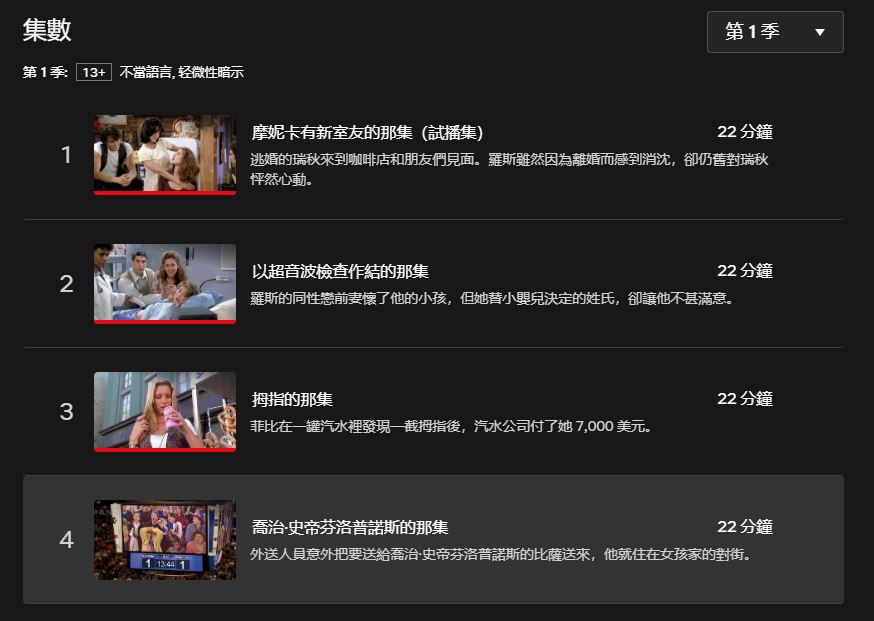

In [ ]:
from IPython.display import Image, display

# 設置圖片的路徑，根據你的雲端硬盤掛載點和具體存儲路徑進行調整
image_path = './img/img01.JPG'

# 顯示圖片
display(Image(filename=image_path))

例如在這第一集中以湯匙作為感情上有進展的代稱，就難以用模型歸納出主題。

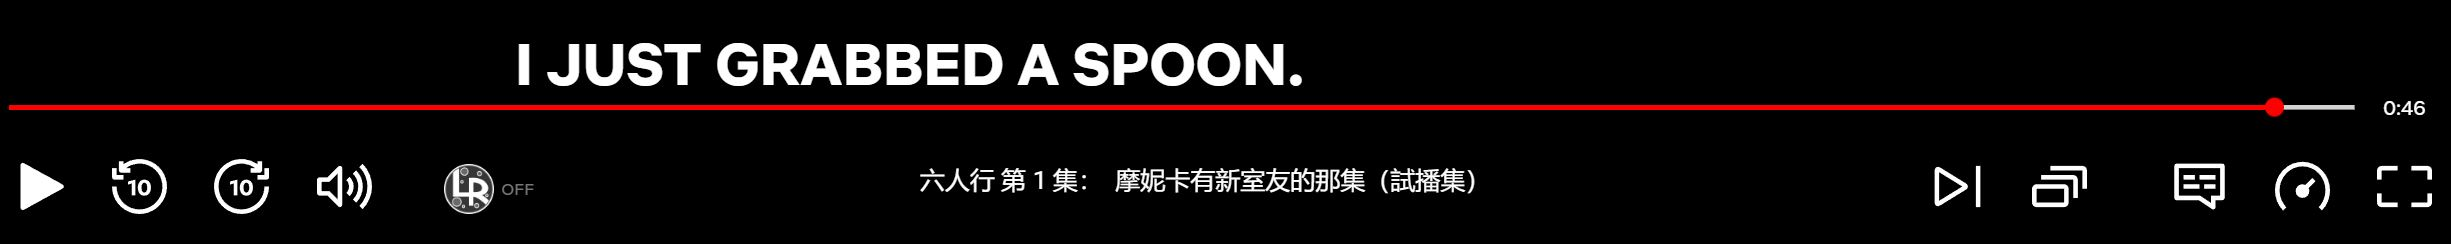

In [ ]:
# 設置圖片的路徑，根據你的雲端硬盤掛載點和具體存儲路徑進行調整
image_path2 = './img/img02.JPG'

# 顯示圖片
display(Image(filename=image_path2))

六人行的劇本並不適合做主題模型訓練，他的劇集的signal多半都包含在人物動作、語氣以及相處的習俗中，單純文本無法很好的作主題模型。